In [1]:
from keypoint_network import build_kpextractor64, build_kpextractor128, preproc_dataset
from train_utils import load_dataset, dataset_loc
import theano.tensor as T
from theano import function as tfn
import cPickle as pickle
import numpy as np
import time
import lasagne.layers as ll
from os.path import join

Couldn't import dot_parser, loading of dot files will not be possible.

+------

<!!! WARNING !!!>
[!custom_layers] WARNING: GPU seems unavailable
<type 'exceptions.ImportError'>: No module named pylearn2.sandbox.cuda_convnet.filter_acts
</!!! WARNING !!!>

L______

Trying /home/zach/envs/thesis/local/lib/python2.7/site-packages/flann-1.8.4-py2.7.egg/pyflann/lib/libflann.so


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)
/home/zach/envs/thesis/local/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
model_loc = 'all_kpts_128_fixedx'
dset_loc = 'all_kpts_128_fixedx'

In [3]:
with open(join(dataset_loc, "Flukes/kpts/%s/model.pkl" % model_loc), 'r') as f:
    model = pickle.load(f)

dset = load_dataset(join(dataset_loc, "Flukes/kpts/%s" % dset_loc), normalize_method='zscore')

Loading /home/zach/data/Flukes/kpts/all_kpts_128_fixedx
Took 7.35 seconds


In [4]:
X = T.tensor4()


kpextractor = build_kpextractor128()
ll.set_all_param_values(kpextractor, model)
model_outputs = [ll.get_output(intr_layer, X, deterministic=True) for intr_layer in ll.get_all_layers(kpextractor)]
#segmenter_out = ll.get_output(segmenter, X, deterministic=True)
kpextractor_fn = tfn([X], model_outputs)

dset_for_model = {section:preproc_dataset(dset[section]) for section in ['train', 'valid', 'test']}

point_outputs = {sec:kpextractor_fn(dset_for_model[sec]['X']) for sec in ['train','valid','test']}

In [5]:
list(enumerate(zip([(np.linalg.norm(i), i.shape) for i in ll.get_all_param_values(kpextractor)],ll.get_all_params(kpextractor))))

[(0, ((2.5153966, (16, 1, 3, 3)), conv1.W)),
 (1, ((0.3201029, (16,)), conv1.b)),
 (2, ((0.21401809, (16,)), beta)),
 (3, ((3.0551553, (16,)), gamma)),
 (4, ((1.4057834, (16,)), mean)),
 (5, ((12.865058, (16,)), inv_std)),
 (6, ((4.8765736, (32, 16, 3, 3)), conv2.W)),
 (7, ((0.16108261, (32,)), conv2.b)),
 (8, ((0.13488829, (32,)), beta)),
 (9, ((4.312295, (32,)), gamma)),
 (10, ((4.2290196, (32,)), mean)),
 (11, ((10.948726, (32,)), inv_std)),
 (12, ((6.5885372, (64, 32, 3, 3)), conv3.W)),
 (13, ((0.10602997, (64,)), conv3.b)),
 (14, ((0.14243594, (64,)), beta)),
 (15, ((6.0949636, (64,)), gamma)),
 (16, ((5.0869775, (64,)), mean)),
 (17, ((12.792576, (64,)), inv_std)),
 (18, ((9.13729, (128, 64, 3, 3)), conv4.W)),
 (19, ((0.093173452, (128,)), conv4.b)),
 (20, ((0.11555233, (128,)), beta)),
 (21, ((8.6189804, (128,)), gamma)),
 (22, ((6.7242393, (128,)), mean)),
 (23, ((19.708488, (128,)), inv_std)),
 (24, ((12.763926, (256, 128, 3, 3)), conv5.W)),
 (25, ((0.077612914, (256,)), conv5

In [6]:
[(ind, i.shape) for ind, i in enumerate(point_outputs['valid'])]

[(0, (815, 1, 128, 128)),
 (1, (815, 16, 128, 128)),
 (2, (815, 16, 64, 64)),
 (3, (815, 16, 64, 64)),
 (4, (815, 32, 64, 64)),
 (5, (815, 32, 32, 32)),
 (6, (815, 32, 32, 32)),
 (7, (815, 64, 32, 32)),
 (8, (815, 64, 16, 16)),
 (9, (815, 64, 16, 16)),
 (10, (815, 128, 16, 16)),
 (11, (815, 128, 8, 8)),
 (12, (815, 128, 8, 8)),
 (13, (815, 256, 8, 8)),
 (14, (815, 256, 4, 4)),
 (15, (815, 256, 4, 4)),
 (16, (815, 512, 4, 4)),
 (17, (815, 512, 2, 2)),
 (18, (815, 512, 2, 2)),
 (19, (815, 256)),
 (20, (815, 256)),
 (21, (815, 64)),
 (22, (815, 64)),
 (23, (815, 6)),
 (24, (815, 3, 2))]

/home/zach/data/Flukes/CRC_combined constrained/4-6-09-NB.jpg
(336, 960)
[[  15.      44.625]
 [ 855.      13.125]
 [ 442.5    244.125]]
[[   2.   17.]
 [ 114.    5.]
 [  59.   93.]]
[[  38.57382965   61.40801239]
 [ 918.88494873    6.40181208]
 [ 484.36975098  196.29948425]]
[[   5.14317703   23.39352798]
 [ 122.51799011    2.43878555]
 [  64.58263397   74.78075409]]
[ 28.93777657  64.23774719  63.56379318]
[  7.1243782    8.89471626  19.05535889]


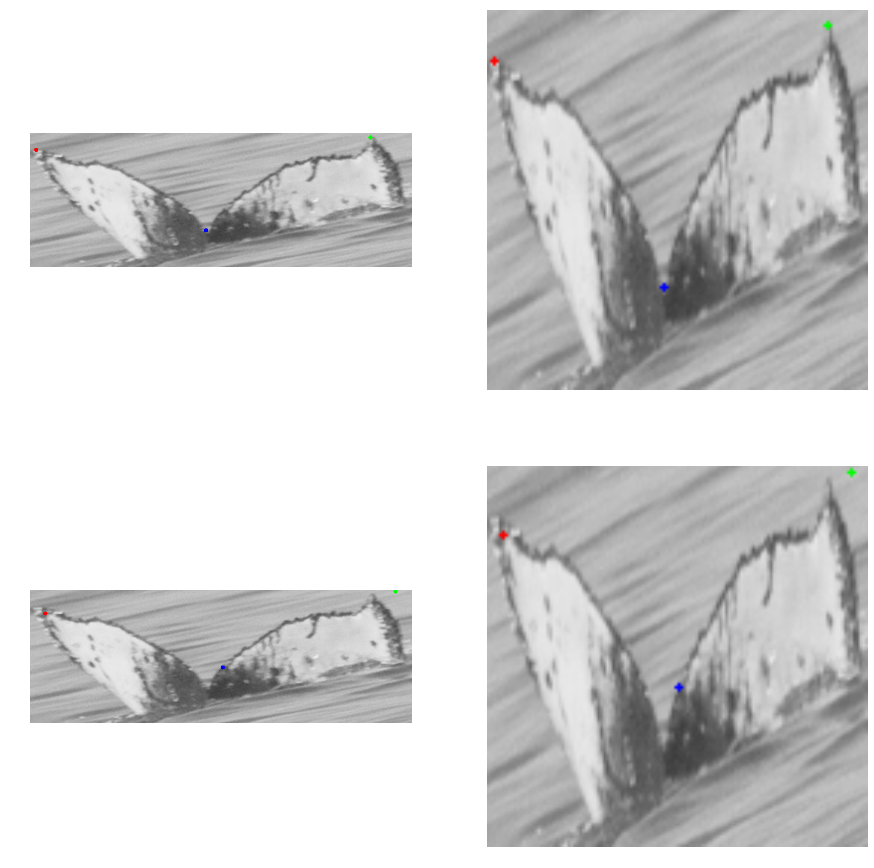

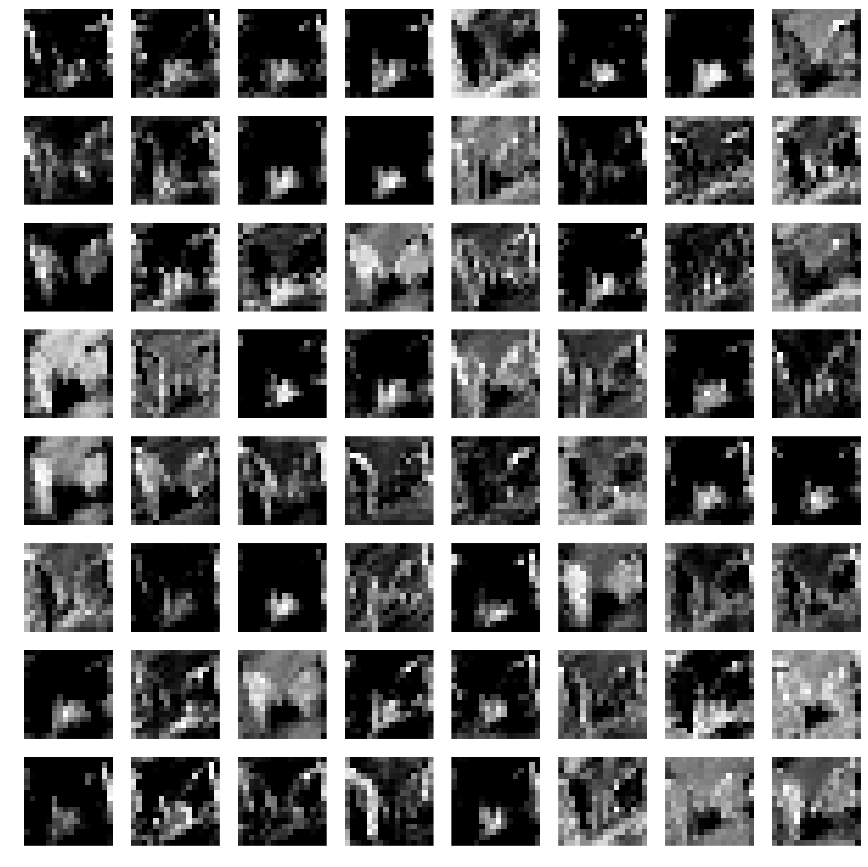

In [7]:
import matplotlib.pyplot as plt
import cv2
import random
%matplotlib inline

def drawPoints(points, img, radius=5):
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    cv2.circle(color_img, (int(points[0,0]), int(points[0,1])), radius, (255,0,0), -1) # left
    cv2.circle(color_img, (int(points[1,0]), int(points[1,1])), radius, (0,255,0), -1) # right
    cv2.circle(color_img, (int(points[2,0]), int(points[2,1])), radius, (0,0,255), -1) # notch
    return color_img

def show_output(originals, true_labels, outputs, ind, stage=-1, imgnames=None, sizes=None):
    # the [0] indexes into the channel
    dset_img = ((originals[ind][0]*dset['std']) + dset['mean']).astype(np.uint8)
    dsety, dsetx = dset_img.shape[:2]
    true_points = true_labels[ind]
    imgname = imgnames[ind]
    print(imgname)
    original_img = cv2.cvtColor(cv2.imread(imgname),cv2.COLOR_BGR2GRAY)
    if sizes is not None:
        original_img = cv2.resize(original_img, tuple(sizes[ind][::-1]), cv2.INTER_LANCZOS4)
    print(original_img.shape)
    origy, origx = original_img.shape[:2]
    #sizey, sizex = original.shape[-2:]
    sizey, sizex = (1.,1.)
    scale_denom = np.array([sizex, sizey]*3,dtype=np.float32).reshape(3,2)
    scale_num_orig = np.array([origx, origy]*3,dtype=np.float32).reshape(3,2)
    scale_num_dset = np.array([dsetx, dsety]*3,dtype=np.float32).reshape(3,2)
    true_points_orig = true_points * (scale_num_orig / scale_denom)
    true_points_dset = true_points * (scale_num_dset / scale_denom)
    print(true_points_orig)
    print(true_points_dset)
    #true_points_scaled = (true_points * scale_mat + scale_mat) / 2 
    # draw left right notch on the original image
    orig_gt_drawn = drawPoints(true_points_orig, original_img)
    dset_gt_drawn = drawPoints(true_points_dset, dset_img, radius=1)
    
    pred_points = outputs[-1][ind]
    #pred_points_scaled = (pred_points * scale_mat + scale_mat) / 2
    pred_points_orig = pred_points * (scale_num_orig / scale_denom)
    pred_points_dset = pred_points * (scale_num_dset / scale_denom)
    print(pred_points_orig)
    print(pred_points_dset)
    pred_drawn_orig = drawPoints(pred_points_orig, original_img)
    pred_drawn_dset = drawPoints(pred_points_dset, dset_img, radius=1)
    print(np.linalg.norm(true_points_orig - pred_points_orig, axis=1))
    print(np.linalg.norm(true_points_dset - pred_points_dset, axis=1))
    network_stage = outputs[stage][ind].swapaxes(0,2)
    #print(output)
    f, trueax = plt.subplots(2,2, figsize=(15,15))
    for i in trueax.flatten():
        i.axis('off')
    trueax[0,0].imshow(orig_gt_drawn)
    trueax[0,1].imshow(dset_gt_drawn)
    trueax[1,0].imshow(pred_drawn_orig)
    trueax[1,1].imshow(pred_drawn_dset)
    
    nfilters = network_stage.shape[-1]
    #print(nfilters)
    square_size = int(np.sqrt(nfilters) + 0.5)
    #print(square_size)
    plt.gray()
    f, netax = plt.subplots(square_size, square_size, figsize=(15,15))
    for i in range(square_size*square_size):
        #netax.set_gray()
        this_ax = netax[i // square_size, i % square_size]
        this_ax.axis('off')
        #this_ax.get_xaxis().set_visible(False)
        #this_ax.get_yaxis().set_visible(False)
        if i < nfilters:
            this_ax.imshow(network_stage[:,:,i].T, interpolation='none')
    #ax[2].imshow(network_stage)

sec = 'valid'
show_output(dset_for_model[sec]['X'], dset_for_model[sec]['y'], point_outputs[sec], 
            random.choice(range(dset_for_model[sec]['X'].shape[0])), stage=8, 
            imgnames=dset_for_model[sec]['names'], sizes=dset_for_model[sec]['extra'])

[[ 0.05885736  0.11799271]
 [ 0.93261117  0.12253643]
 [ 0.49041411  0.51655483]]
[[ 0.06153065  0.11999682]
 [ 0.93601859  0.12369602]
 [ 0.49124107  0.51383662]]
0.0496352
0.0873901
0.0883697


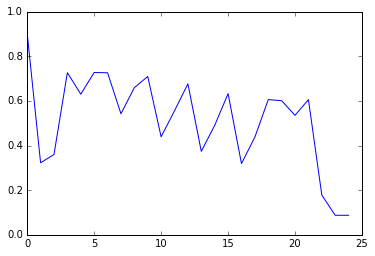

In [8]:
#print(len(point_outputs_valid))
n_layers = len(point_outputs[sec])
#plt.yscale('log')
plt.plot([np.average(np.std(point_outputs[sec][i],axis=0)) for i in range(n_layers)])
avg_prediction = np.average(dset_for_model[sec]['y'],axis=0)
print(avg_prediction)
print(np.average(point_outputs[sec][-1],axis=0))
def eucl_loss(pred, y):
    return np.average(np.linalg.norm(pred - y, axis=2),axis=(0,1))

print(eucl_loss(point_outputs[sec][-1], dset_for_model[sec]['y']))
print(np.average(np.std(point_outputs[sec][-1],axis=0)))
print(np.average(np.std(dset_for_model[sec]['y'],axis=0)))

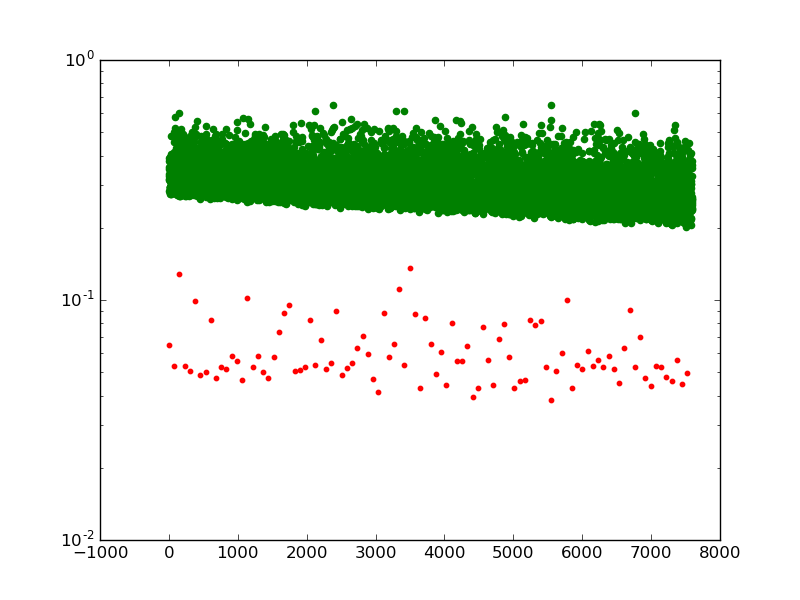

In [9]:
from IPython.display import Image 
Image(filename='./losses.png')

In [10]:
# let's see the worst cases by original size
sec = 'train'
def get_gt_dist(true_pt, pred_pt, sizes):
    #sizey, sizex = (1.,1.)
    sizes = sizes[:,::-1]
    #scale_denom = np.array([sizex, sizey]*3,dtype=np.float32).reshape(3,2)
    scale_num_orig = np.stack([sizes, sizes, sizes],axis=1).astype(np.float32)
    #scale_num_dset = np.array([dsetx, dsety]*3,dtype=np.float32).reshape(3,2)
    true_points_orig = true_pt * (scale_num_orig)
    #true_points_dset = true_points * (scale_num_dset / scale_denom)
    pred_points_orig = pred_pt * (scale_num_orig)
    dists = np.linalg.norm(true_points_orig - pred_points_orig, axis=2)
    #print(dists)
    return dists

np.average(get_gt_dist(dset_for_model[sec]['y'], point_outputs[sec][-1], dset_for_model[sec]['extra']),axis=0)

array([ 20.53520012,  20.74338341,  13.73280907], dtype=float32)

In [13]:
# Export model params and dataset so that IBEIS can use it
model_ibs = {'params':model, 'mean':dset['mean'], 'std':dset['std']}
print(model_ibs['mean'].shape)

(128,)
